Piotr Janczyk  
PJN

# Named entity recognition

In [1]:
from glob import glob
import pandas as pd
import regex
from typing import NamedTuple, List, Iterator, Tuple
from tqdm import tqdm
import requests
from collections import Counter, defaultdict
import json
import time
from xml.etree import ElementTree
import matplotlib.pyplot as plt

In [2]:
def read_file(filename: str) -> str:
    with open(filename, "r") as f:
        return f.read()

filenames = sorted(glob("../ustawy-v2/*.txt"))

acts = pd.DataFrame({
  "id": [regex.match(r"\.\./ustawy-v2/(\d+_\d+)\.txt", filename).group(1) for filename in filenames],
  "text": [read_file(filename) for filename in filenames]
})

#### _4\. Sort bills according to their size and take top 50 (largest) bills._

In [3]:
acts["length"] = [len(text) for text in acts["text"]]
acts = acts.sort_values(by='length')
acts = acts.tail(50)

In [4]:
pd.set_option('display.max_rows', 6)

acts

,id,text,length
701,2001_1444,"\n\n\n\nDz.U. z 2001 r. Nr 129, poz. 1444\n ...",129257
231,1997_153,"\n\n\n\nDz.U. z 1997 r. Nr 28, poz. 153\n ...",131863
802,2001_92,"\n\n\n\nDz.U. z 2001 r. Nr 12, poz. 92\n ...",136040
...,...,...,...
174,1996_465,"\n\n\n\nDz.U. z 2000 r. Nr 94, poz. 1037\n ...",396433
754,2001_627,"\n\n\n\nDz.U. z 2001 r. Nr 62, poz. 627\n ...",397912
591,2000_696,"\n\n\n\nDz.U. z 1998 r. Nr 106, poz. 668\n ...",560054


#### _5\. Use the lemmatized and sentence split documents ... to identify the expressions that consist of consecutive words starting with a capital letter ... that do not occupy the first position in a sentence._

In [5]:
def tag_text(text: str) -> str:
    response = requests.post("http://localhost:9200", data=text.replace("\n", " ").encode("utf-8"))
    return response.content.decode("utf-8")

In [6]:
# acts["tagger_output"] = [tag_text(text) for text in tqdm(acts["text"])]
# acts.to_csv("tagged.csv")
acts = pd.read_csv("tagged.csv", index_col=0)

In [7]:
tagger_output: str = "".join(acts["tagger_output"])

In [8]:
class Token(NamedTuple):
    word: str
    lemma: str
    category: str

    def __repr__(self):
        return f"{self.word} ({self.lemma}:{self.category})"

Sentence = List[Token]

def extract_sentences_and_tokens(tagger_output: str) -> List[Sentence]:
    lines = tagger_output.split("\n")
    sentences = []
    words = []

    for i, line in enumerate(lines):
        if line == "":
            if len(words) > 0:
                sentences.append(words)
                words = []
        elif line.startswith("\t"):
            prev_line = lines[i - 1]
            words.append(
                Token(
                    word=prev_line.split("\t")[0],
                    lemma=line.split("\t")[1].lower(),
                    category=line.split("\t")[2].split(":")[0],
                )
            )
        
    return sentences

In [9]:
sentences = extract_sentences_and_tokens(tagger_output)

In [10]:
sentences[50]

[Kierujący (kierować:pact),
 rowerem (rower:subst),
 jednośladowym (jednośladowy:adj),
 jest (być:fin),
 obowiązany (obowiązany:adj),
 korzystać (korzystać:inf),
 z (z:prep),
 drogi (droga:subst),
 dla (dla:prep),
 rowerów (rower:subst),
 lub (lub:conj),
 z (z:prep),
 drogi (droga:subst),
 dla (dla:prep),
 rowerów (rower:subst),
 i (i:conj),
 pieszych (pieszy:adj),
 . (.:interp)]

In [11]:
def recognize_named_entities(sentences: List[Sentence]) -> Iterator[str]:
    def process_sentence(sentence: Sentence) -> List[str]:
        start_of_sentence = True
        named_entity = []
        for token in sentence:
            if token.word[0].isupper():
                named_entity.append(token.lemma)
            else:
                if len(named_entity) > 0 and not start_of_sentence:
                    yield " ".join(named_entity)
                start_of_sentence = False
                named_entity = []

    return [
        entity
        for sentence in sentences
        for entity in process_sentence(sentence)
    ]

In [12]:
named_entities = recognize_named_entities(sentences)

#### _6\. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences._

In [13]:
pd.set_option('display.max_rows', None)

common_named_entities = Counter(named_entities).most_common(50)
pd.DataFrame.from_records(common_named_entities,
                          columns=["named_entity", "count"],
                          index="named_entity")

,count
named_entity,
numer,4583
artykuł,1840
dziennik,1599
ustawa,1516
rzeczpospolita polski,704
kodeks,499
policja,454
skarb państwo,389
prawo,330


#### _7\. Apply the NER algorithm to identify the named entities ... using the n82 model._

In [14]:
USER='janczyk@student.agh.edu.pl'

def clarin_ner_process(text: str, lpmn: str) -> str:
    source_file = requests \
        .post(
            "http://ws.clarin-pl.eu/nlprest2/base/upload",
            data=text.encode("utf-8"),
            headers={'Content-Type': 'binary/octet-stream'}
        ) \
        .text

    task_id = requests \
        .post(
            "http://ws.clarin-pl.eu/nlprest2/base/startTask/",
            json={"user": USER, "lpmn": lpmn, "file": source_file}
        ) \
        .text

    while True:
        time.sleep(0.5)

        status = requests \
            .get(f"http://ws.clarin-pl.eu/nlprest2/base/getStatus/{task_id}") \
            .json()

        if status["status"] == "ERROR":
            raise Exception(f"Error {data['value']}")
        elif status["status"] == "DONE":
            processed_file = status["value"][0]["fileID"]
            break

    return requests \
        .get(f"http://ws.clarin-pl.eu/nlprest2/base/download{processed_file}") \
        .text
    
print(
    clarin_ner_process(
        text="Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.",
        lpmn='any2txt|wcrft2|liner2({"model":"n82"})'
    )
)

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE chunkList SYSTEM "ccl.dtd">
<chunkList>
 <chunk type="p" id="ch1">
  <sentence id="s1">
   <tok>
    <orth>Wczoraj</orth>
    <lex disamb="1"><base>wczoraj</base><ctag>adv:pos</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>w</orth>
    <lex disamb="1"><base>w</base><ctag>prep:acc:nwok</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>Krakowie</orth>
    <lex disamb="1"><base>Krak</base><ctag>subst:pl:nom:m1</ctag></lex>
    <ann chan="nam_loc_gpe_city" head="1">1</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>miało</orth>
    <lex disamb="1"><base>mieć</base><ctag>praet:sg:n:imperf</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>miejsce</orth>
    <lex disamb="1"><base>miejs

In [15]:
# for _, act in tqdm(acts.iterrows()):
#     cll = clarin_ner_process(act["text"], lpmn='any2txt|wcrft2|liner2({"model":"n82"})')
#     with open(f"./ner/{act['id']}.cll", 'w') as f:
#         f.write(cll)

In [16]:
class NamedEntity(NamedTuple):
    words: str
    coarse_grained_type: str
    fine_grained_type: str

    def __repr__(self):
        return f"{' '.join(self.words)} ({self.coarse_grained_type} {self.fine_grained_type})"

def extract_named_entities_from_cll(filename: str) -> List[NamedEntity]:
    result = []
    root = ElementTree.parse(filename).getroot()

    for sentence in root.iter("sentence"):
        current_entities = defaultdict(list)
        for token in sentence.findall("tok"):
            lemma = token.find("lex").find("base").text
            for annotation in token.findall("ann"):
                no = int(annotation.text)
                class_ = annotation.attrib["chan"]
                if no > 0:
                    current_entities[(class_, no)].append(lemma)
        
        result += [
            NamedEntity(
                words=" ".join(words),
                coarse_grained_type=class_[0:7],
                fine_grained_type=class_,
            )
            for (class_, _), words in current_entities.items()
        ]

    return result

In [17]:
entities = [
    entity
    for act_id in tqdm(acts["id"])
    for entity in extract_named_entities_from_cll(f"./ner/{act_id}.cll")
]

entities_df = pd.DataFrame.from_records(entities, columns=["words", "coarse_grained_type", "fine_grained_type"])

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


#### _8\. Plot the frequency (histogram) of the coarse-grained classes_

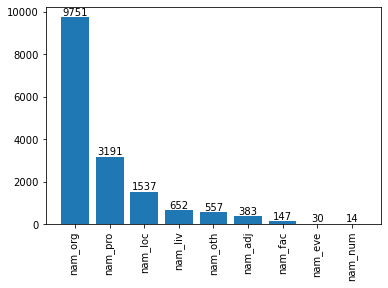

In [18]:
coarse_grained_type_frequency = (
    entities_df
        .groupby("coarse_grained_type")
        .size()
        .sort_values(ascending=False)
)

rects = plt.bar(
    coarse_grained_type_frequency.index,
    coarse_grained_type_frequency.values
)
plt.xticks(rotation="vertical")
for rect in rects:
    height = rect.get_height()
    plt.annotate(
        str(height),
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='bottom'
    )


#### _9\. Display 10 most frequent Named Entities for each coarse-grained type._

In [19]:
pd.set_option('display.max_rows', None)

entities_df \
    .groupby("coarse_grained_type") \
    .apply(
        lambda group: group
            .groupby(["words", "fine_grained_type"])
            .size()
            .nlargest(10)
    ) \
    .to_frame("count")

count
coarse_grained_type words                               fine_grained_type            
nam_adj             polski                              nam_adj_country           204
                    wojewódzki                          nam_adj_country            20
                    europejski                          nam_adj_other              15
                    mazowiecki                          nam_adj_other               7
                    internetowy                         nam_adj_other               5
                    macierzyński                        nam_adj_country             3
                    warszawski                          nam_adj_city                3
                    afrykański                          nam_adj_country             2
                    brzeski                             nam_adj_country             2
                    chełmiński                          nam_adj_country             2
nam_eve             euro                                nam_eve_human_sport         5
                    maksymalny limit pozostałość        nam_eve_human               3
                    monitor sądowy                      nam_eve_human_sport         2
                    przejściowy plan krajowy            nam_eve_human               2
                    II wojna światowy                   nam_eve_other               1
                    R5 recykling                        nam_eve_human               1
                    X . opieka domowy nad dziecko       nam_eve_human               1
                    europejski kart społeczny           nam_eve_human_sport         1
                    generalny konserwator zabytek       nam_eve_human               1
                    inspektor nadzór wewnętrzny         nam_eve_human               1
nam_fac             inspektor nadzór wewnętrzny         nam_fac_goe                50
                    komendant główny                    nam_fac_goe                16
                    straż graniczny                     nam_fac_goe                13
                    mangan                              nam_fac_goe                 8
                    obrona narodowy                     nam_fac_goe                 6
                    krajowy rejestr karny               nam_fac_goe                 5
                    molibden                            nam_fac_goe                 4
                    zasłużony dawca przeszczep          nam_fac_goe                 4
                    zatoka gdańska                      nam_fac_goe                 4
                    MN                                  nam_fac_goe                 3
nam_liv             kasa chora                          nam_liv_person            109
                    Pan                                 nam_liv_god                38
                    straż graniczny                     nam_liv_person             36
                    krajowy depozyt                     nam_liv_person             25
                    siła zbrojny                        nam_liv_person             24
                    Art                                 nam_liv_person             18
                    gospodarka żywnościowy              nam_liv_person             16
                    główny inspektor                    nam_liv_person             16
                    najwyższy                           nam_liv_person             13
                    główny lekarz weterynaria           nam_liv_person             11
nam_loc             rzeczpospolita polski               nam_loc_gpe_country       812
                    Rzeczpospolita Polska               nam_loc_gpe_country        91
                    Polska                              nam_loc_gpe_country        72
                    Warszawa                            nam_loc_gpe_city           70
                    nawóz                               nam_loc_gpe_city           28
                    konfederacja szwaj

#### _10\. Display 50 most frequent Named Entities including their count and fine-grained type._

In [20]:
pd.set_option('display.max_rows', None)

entities_df \
    .groupby(["words", "fine_grained_type"]) \
    .size() \
    .nlargest(50) \
    .to_frame("count")

,,count
words,fine_grained_type,
Dzieje_(Apostolskie) . u .,nam_pro_media_periodic,1097
rzeczpospolita polski,nam_loc_gpe_country,812
dziennik . u .,nam_pro_media_periodic,438
skarb państwo,nam_org_institution,410
złoty,nam_oth_currency,334
minister sprawiedliwość,nam_org_institution,322
unia europejski,nam_org_organization,296
minister obrona narodowy,nam_org_institution,287
rada minister,nam_org_institution,279


#### _11\. Answer the following questions:_

**i. _Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?_**

NER działa istotnie lepiej. 

Około połowa z 50 najczęstszych wyników uzyskanych przez algorytm oparty o wielkie litery to wyrazy, które nie są jednostami nazewniczymi.
W przypadku NER ten odsetek jest istotnie mniejszy.

**ii. _What are the drawbacks of the method based on capital letters?_**

Nie obsługuje on poniższych przypadków:
* nazwy własne zawierające wyrazy zaczynające się od małych liter (np. "Minister Zdrowia i Opieki Społecznej", "Prawo ochrony środowiska"),
* jednostki nazewnicze występujące na początku zdania,
* tekst pisany wielkimi literami (np. "USTAWA", "XXI"),

**iii. _What are the drawbacks of the method based on NER?_**

W przypadku korzystania z publicznego API Clarin, głównym problem był czas oczekiwania na przetworzenie tekstów. Czas przetworzenia 50 ustaw wyniósł około 5 godzin. (Aczkolwiek myślę, że można by to rozwiązać uruchamiając algorytm na własnym komputerze/serwerze).

**iv. _Which of the coarse-grained NER groups has the best and which has the worst results?
Try to justify this observation._**

Źle wypadły:
* `nam_liv` (nazwy istot żywych) — zostały tam zaklasyfikowane frazy takie jak: "kasa chorych", "Pan" (sklasyfikowany jako nazwa bóstwa z Mitologii Greckiej), "krajowy depozyt".
* `nam_eve` (nazwy wydażeń) — z 10 najczęstszych dopasowań większość nie jest wydarzeniami. Szczególnie trudnym przypadkiem jest "EURO", które było czasami było klasyfikowane jako nazwa waluty, a czasami jako nazwa wydarzenia sportowego — algorytm nie był w stanie poprawnie wywnioskować znaczenia z kontekstu.

Dobrze wypadły: `nam_org` (nazwy organizacji — głównie nazwy własne urzędów i stanowisk) oraz `nam_pro` (głównie nazwy własne dokumentów i czasopism). Te kategorie zawierają dość długie nazwy własne charakterystyczne dla języka prawniczego. W przeciwieństwie do krótkich nazw z innych kategorii (np. wspomniane powyżej "EURO" i "Pan") mają tylko jedno znaczenie.

**v. _Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?_**

NER nie daje nam informacji o kanonicznej formie jednostki nazewniczej. W postaci zlematyzowanej mamy "USA" i "stan zjednoczony". Moglibyśmy użyć słownika synonimów w celu powiązania tych form.

**vi. _Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?_**

* Automatyczne generowanie odnośników do definicji nazw własnych w encyklopedii (podobnie do Wikipedii)
* Automatyczne generowanie indeksu książki (spisu pojęć użytych w danej książce)